In [98]:
import numpy as np
import matplotlib.pyplot as plt
from ode_solver import ODESolver
from prettytable import PrettyTable
from scipy import interpolate

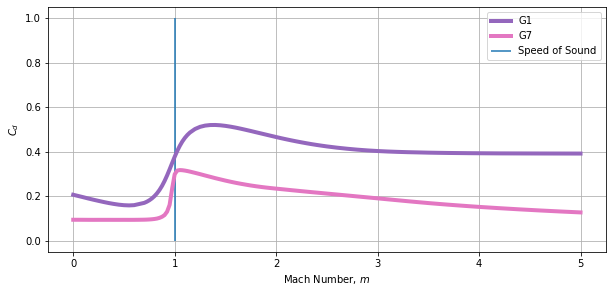

In [99]:
# Load in the data for the reference coefficients of drag for G1 and G7 bullets
g1_drag_data = np.genfromtxt('./g1_drag_data.txt')
g7_drag_data = np.genfromtxt('./g7_drag_data.txt')

# Convert from K_d to C_d?
g1_drag_data[:, 1] *= np.pi/4
g7_drag_data[:, 1] *= np.pi/4

# Plot the G1 and G7 data
plt.subplots(figsize=(10, 4.5))
plt.plot(g1_drag_data[:, 0], g1_drag_data[:, 1], c='C4', lw=4)
plt.plot(g7_drag_data[:, 0], g7_drag_data[:, 1], c='C6', lw=4)
plt.vlines(1.0, ymin=0, ymax=1)
plt.legend(['G1', 'G7', 'Speed of Sound'])
plt.xlabel(r'Mach Number, $m$')
plt.ylabel(r'$C_d$')
plt.grid()
plt.show()

In [100]:
# Define the derivative solver.
def projectile(t, y, b):
    """
    Takes in a position and velocity vector, returns the derivative, a velocity and acceleration vector.
    In this cas we have position, velocity = (x, y, vx, vy)
    and velocity, acceleration = (vx, vy, ax, ay)

    t is not used
    y is the input state
    b is an object containing the ballistic model
    returns dy/dt
    """
    # x and y velocities
    vx = y[2]
    vy = y[3]

    # v magnitude
    v_mag = np.sqrt(vx ** 2 + vy ** 2)

    # Drag force
    Fd = b.get_drag(v_mag)

    # x and y acceleration
    ax = -Fd * (vx / v_mag)  # The vx/v_mag is the Fdx component of Fd
    ay = -b.g - Fd * (vy / v_mag)  # The vy/v_mag is the Fdy component of Fd

    return np.array([vx, vy, ax, ay])



class BallisticCoefficient:
    """ Object represents the aerodynamic properties of a user-designated caliber bullet """

    def __init__(self, caliber, bc, rho, vs, drag_ref_data, units='imperial'):
        """

        :param caliber: Caliber of the projectile
        :param bc: ballistic coefficient of the projectile
        :param units: metric or imperial
        :param drag_ref_data
        """
        self.caliber = caliber
        self.bc = bc
        self.rho = rho
        self.vs = vs
        self.units = units
        self.drag_ref_data = drag_ref_data

        if units == 'imperial':
            self.g = 32.2
        if units == 'metric':
            self.g = 9.8

    def get_drag(self, v):
        """
        Takes in a velocity magnitude. Returns the magnitude of the drag resistance.

        :param v:
        :return:
        """
        # Assumes imperial units for now

        # Compute mach number and reference coefficient of drag
        vm = v / self.vs
        Cdg = np.interp(vm, self.drag_ref_data[:, 0], self.drag_ref_data[:, 1])

        force_of_drag = (1 / 2) * (1 / self.bc) * self.rho * Cdg * v**2
        return force_of_drag


In [101]:
# Run simulation with the 6.5mm Creedmoor 144gr Long Range Hybrid Target
# Has G1 BC: 0.655 lb/in^2
# And G7 BC: 0.336 lb/in^2
# with muzzle velocity 2830 ft/s
# https://bergerbullets.com/information/lines-and-designs/long-range-hybrid-target-bullets/

# Load in observed data for the above round
bullet_data = np.genfromtxt('./berger_6_5_creedmoor_144gr_data.txt')
bullet_data[:, 0] *= 3    # convert range from yards to feet
bullet_data[:, 2] /= 12   # Convert drop from inches to feet

# Ballistics Data for the round to the ballistics object
# Assume temp celsius = 20
air_density = 0.07517           # lb/ft^3
speed_of_sound = 1126           # ft/s
g1_ballistics = BallisticCoefficient('6.5 Creedmoor', bc=94.32, rho=air_density, vs=speed_of_sound,
                                 drag_ref_data=g1_drag_data, units='imperial')
g7_ballistics = BallisticCoefficient('6.5 Creedmoor', bc=48.38, rho=air_density, vs=speed_of_sound,
                                 drag_ref_data=g7_drag_data, units='imperial')

# Parameters for the ODE solver
t_range = np.array([0, 1.4])                # x range in feet
v_muzzle = 2830                             # ft/s
dist_between_barrel_and_scope = 0.164       # in feet
theta = np.pi / 180 / 12
vx_0 = v_muzzle * np.cos(theta)             # Initial x velocity
vy_0 = v_muzzle * np.sin(theta)             # Initial y velocity
initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])   # position in inches, velocity in ft/s

# Solve the ODE for G1 and G7 Ballistic Coefficients
ode_solver = ODESolver()
t_g1, y_g1 = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g1_ballistics,
                             first_step=1e-4)
t_g7, y_g7 = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                             first_step=1e-4)
v_g1 = np.sqrt(y_g1[:, 2] ** 2 + y_g1[:, 3] ** 2)
v_g7 = np.sqrt(y_g7[:, 2] ** 2 + y_g7[:, 3] ** 2)

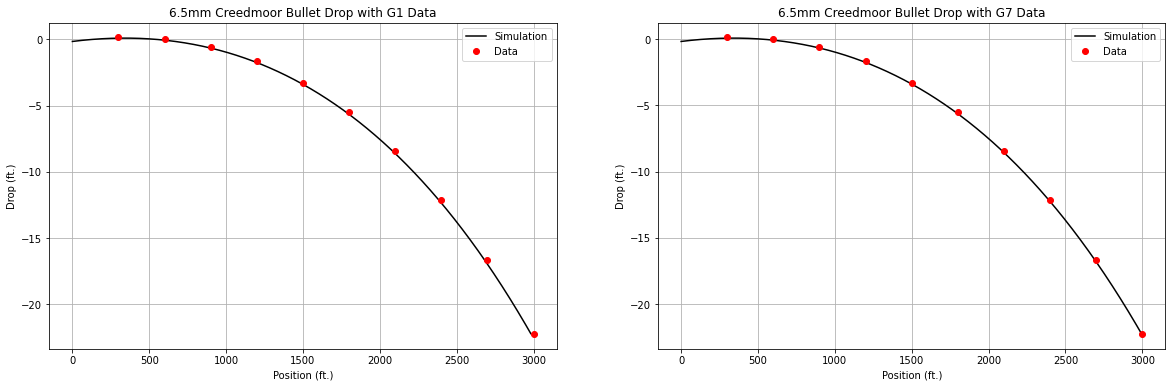

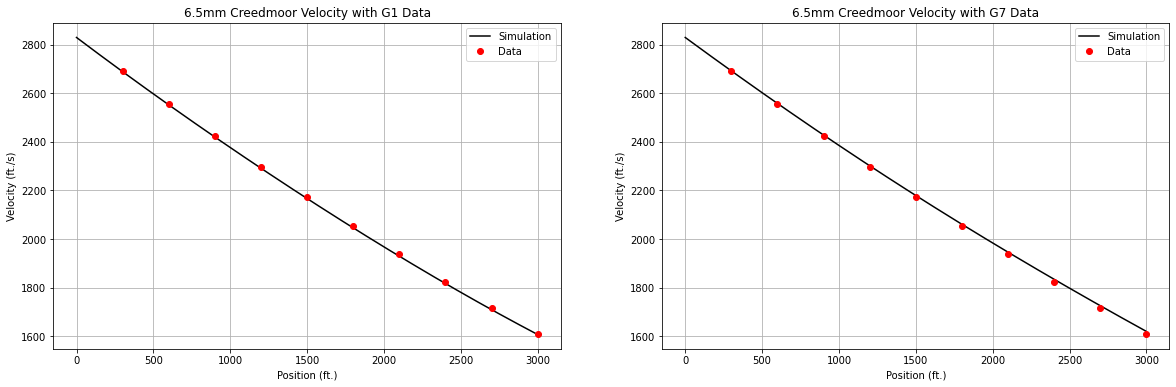

In [102]:
# Plot the results
# Bullet Drop
fig_d, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(y_g1[:, 0], y_g1[:, 1], 'k-')
axs[0].plot(bullet_data[:, 0], bullet_data[:, 2], 'ro')
axs[0].set_title('6.5mm Creedmoor Bullet Drop with G1 Data')
axs[0].legend(['Simulation', 'Data'])
axs[0].set(xlabel='Position (ft.)', ylabel='Drop (ft.)')
axs[0].grid()
axs[1].plot(y_g7[:, 0], y_g7[:, 1], 'k-')
axs[1].plot(bullet_data[:, 0], bullet_data[:, 2], 'ro')
axs[1].set_title('6.5mm Creedmoor Bullet Drop with G7 Data')
axs[1].legend(['Simulation', 'Data'])
axs[1].set(xlabel='Position (ft.)', ylabel='Drop (ft.)')
axs[1].grid()
plt.show()

# Velocity
fig_v, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(y_g1[:, 0], v_g1, 'k-')
axs[0].plot(bullet_data[:, 0], bullet_data[:, 1], 'ro')
axs[0].set_title('6.5mm Creedmoor Velocity with G1 Data')
axs[0].set(xlabel='Position (ft.)', ylabel='Velocity (ft./s)')
axs[0].legend(['Simulation', 'Data'])
axs[0].grid()
axs[1].plot(y_g7[:, 0], v_g7, 'k-')
axs[1].plot(bullet_data[:, 0], bullet_data[:, 1], 'ro')
axs[1].set_title('6.5mm Creedmoor Velocity with G7 Data')
axs[1].set(xlabel='Position (ft.)', ylabel='Velocity (ft./s)')
axs[1].legend(['Simulation', 'Data'])
axs[1].grid()
plt.show()

In [103]:
# Interpolate the simulated data to find the drop and velocity at the observed data distances
y_g1_interpolated = np.interp(bullet_data[:, 0], y_g1[:, 0], y_g1[:, 1])
v_g1_interpolated = np.interp(bullet_data[:, 0], y_g1[:, 0], v_g1)
y_g7_interpolated = np.interp(bullet_data[:, 0], y_g7[:, 0], y_g7[:, 1])
v_g7_interpolated = np.interp(bullet_data[:, 0], y_g7[:, 0], v_g7)

# Compute Errors for position and velocity between observed and simulated data
y_g1_error = bullet_data[:, 2] - y_g1_interpolated
v_g1_error = bullet_data[:, 1] - v_g1_interpolated
y_g7_error = bullet_data[:, 2] - y_g7_interpolated
v_g7_error = bullet_data[:, 1] - v_g7_interpolated

# Display the results
# G1 Table
table_g1 = PrettyTable()
table_g1.title = '6.5mm Creedmoor Simulated Bullet Drop/Velocity with G1 Data'
table_g1.field_names = ['Distance (ft.)', *bullet_data[:, 0], 'RMSE']
table_g1.add_row(['Drop (ft)', *y_g1_interpolated, '-'])
table_g1.add_row(['Drop Error (ft)', *y_g1_error, np.sqrt(np.mean(y_g1_error)**2)])
table_g1.add_row(['Velocity (ft/s)', *v_g1_interpolated, '-'])
table_g1.add_row(['Velocity Error (ft/s)', *v_g1_error, np.sqrt(np.mean(v_g1_error)**2)])
table_g1.float_format = '0.3'
print(table_g1)

# G7 Table
table_g7 = PrettyTable()
table_g7.title = '6.5mm Creedmoor Simulated Bullet Drop/Velocity with G7 Data'
table_g7.field_names = ['Distance (ft.)', *bullet_data[:, 0], 'RMSE']
table_g7.add_row(['Drop (ft)', *y_g7_interpolated, '-'])
table_g7.add_row(['Drop Error (ft)', *y_g7_error, np.sqrt(np.mean(y_g7_error)**2)])
table_g7.add_row(['Velocity (ft/s)', *v_g7_interpolated, '-'])
table_g7.add_row(['Velocity Error (ft/s)', *v_g7_error, np.sqrt(np.mean(v_g7_error)**2)])
table_g7.float_format = '0.3'
print()
print(table_g7)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                         6.5mm Creedmoor Simulated Bullet Drop/Velocity with G1 Data                                         |
+-----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------+
|     Distance (ft.)    |  300.0   |  600.0   |  900.0   |  1200.0  |  1500.0  |  1800.0  |  2100.0  |  2400.0  |  2700.0  |  3000.0  |  RMSE |
+-----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------+
|       Drop (ft)       |  0.085   |  -0.067  |  -0.664  |  -1.757  |  -3.402  |  -5.666  |  -8.623  | -12.359  | -16.975  | -22.223  |   -   |
|    Drop Error (ft)    |  0.052   |  0.067   |  0.083   |  0.102   |  0.124   |  0.152   |  0.185   |  0.227   |  0.277   |  -0.025  | 

## Thoughts on the above and ideas for improvement ##
Firstly, it looks like the modeled 6.5 Creedmoor performs closely to the observed data. The bullet drop error is
slightly better for the G7 drag coefficients, but the velocity error is slightly better for the G1 drag coefficients.
To dive into this a little further, the velocity is split almost evenly between the G1 and G7. With the exception of
the furthest distance at 1000 yards, the G1 overestimates velocity and the G7 underestimates velocity. I wonder if a
bullet model that were somewhere in between the G1 and G7 would better fit this data? Unfortunately, the manufactorer
only lists ballistic coefficients for the G1 and G7, so I won't dive into trying out other reference drag coefficients.

__Ideas for Improvement__

**1)** I picked values of theta by hand until I got something that looked reasonable. I was inspired by Fred's two-stage
approach for finding an optimum theta, so I'll implement something similar in order to try and reduce my drop error.

**2)** I use numpy's linear interpolation to find the reference drag coefficients when computing $F_d$, but the data
for the drag coefficient is clearly nonlinear. I saw Hannah build a scipy interpolation function into her Ballistic
Coefficient class and use that for computing the reference drag. I'll try changing to this method to see if it improves
my velocity error.

**3)** Lastly, I picked a temperature at random and input the appropriate air density parameters. However, the
manufacturer's website states "Performance based on a 26″ barrel and sea level conditions". I wonder if I can find
parameters that better meet this specification.

### Improvement Idea 1) Find an Optimal Theta###
Below, I take a two stage approach to find a better theta. First, I geometrically sample different values of theta until
I find a saddle. Next, I compare different values of theta within the saddle range to find the best.

In [104]:
# STEP 1: Geometrically sample thetas
theta = np.pi / 180 / 12
print(f'old theta is {theta}')
zero_drop_prev = 1000.
for n in np.geomspace(1, 80, num=20):
    theta = np.pi / 180 / n
    vx_0 = v_muzzle * np.cos(theta)  # Initial x velocity
    vy_0 = v_muzzle * np.sin(theta)  # Initial y velocity
    initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])  # position in inches, velocity in ft/s

    # Solve the ODE with the proposed value of theta
    t, y = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                                first_step=1e-4)

    # Compute the error at distance = 600 ft. (zero-distance) to evaluate the best theta
    zero_drop_interp = interpolate.interp1d(y[:, 0], y[:, 1], kind='quadratic')
    zero_drop = float(zero_drop_interp(600))
    if zero_drop < 0 and zero_drop_prev > 0:
        low_theta = theta
        break
    zero_drop_prev = zero_drop
    high_theta = theta

print(f'Best theta is in the range {low_theta}, {high_theta}')

# Now perform a fine search in the range [low_theta, high_theta]
best_theta = 0
best_error = 1000
for theta in np.linspace(low_theta, high_theta, 50):
    vx_0 = v_muzzle * np.cos(theta)  # Initial x velocity
    vy_0 = v_muzzle * np.sin(theta)  # Initial y velocity
    initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])  # position in inches, velocity in ft/s

    # Solve the ODE with the proposed value of theta
    t, y = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                                first_step=1e-4)

    # Compute the error at distance = 600 ft. (zero-distance) to evaluate the best theta
    zero_drop_interp = interpolate.interp1d(y[:, 0], y[:, 1], kind='quadratic')
    zero_drop = float(zero_drop_interp(600))
    error = np.square(zero_drop)
    if error < best_error:
        best_error = error
        best_theta = theta


print(f'new best theta is {best_theta} with error {best_error}')

old theta is 0.001454441043328608
Best theta is in the range 0.0013806653566087973, 0.0017388057138552572
new best theta is 0.0015633900286733176 with error 7.643055304366718e-08


In [105]:
# Test the new theta
theta = best_theta
vx_0 = v_muzzle * np.cos(theta)             # Initial x velocity
vy_0 = v_muzzle * np.sin(theta)             # Initial y velocity
initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])   # position in inches, velocity in ft/s
t_g1, y_g1 = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g1_ballistics,
                             first_step=1e-4)
t_g7, y_g7 = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                             first_step=1e-4)
v_g1 = np.sqrt(y_g1[:, 2] ** 2 + y_g1[:, 3] ** 2)
v_g7 = np.sqrt(y_g7[:, 2] ** 2 + y_g7[:, 3] ** 2)

# Interpolate the simulated data to find the drop and velocity at the observed data distances
y_g1_interpolated = np.interp(bullet_data[:, 0], y_g1[:, 0], y_g1[:, 1])
v_g1_interpolated = np.interp(bullet_data[:, 0], y_g1[:, 0], v_g1)
y_g7_interpolated = np.interp(bullet_data[:, 0], y_g7[:, 0], y_g7[:, 1])
v_g7_interpolated = np.interp(bullet_data[:, 0], y_g7[:, 0], v_g7)

# Compute Errors for position and velocity between observed and simulated data
y_g1_error = bullet_data[:, 2] - y_g1_interpolated
v_g1_error = bullet_data[:, 1] - v_g1_interpolated
y_g7_error = bullet_data[:, 2] - y_g7_interpolated
v_g7_error = bullet_data[:, 1] - v_g7_interpolated

# Display the results
# G1 Table
table_g1 = PrettyTable()
table_g1.title = '6.5mm Creedmoor Simulated Bullet Drop/Velocity with G1 Data'
table_g1.field_names = ['Distance (ft.)', *bullet_data[:, 0], 'RMSE']
table_g1.add_row(['Drop (ft)', *y_g1_interpolated, '-'])
table_g1.add_row(['Drop Error (ft)', *y_g1_error, np.sqrt(np.mean(y_g1_error)**2)])
table_g1.add_row(['Velocity (ft/s)', *v_g1_interpolated, '-'])
table_g1.add_row(['Velocity Error (ft/s)', *v_g1_error, np.sqrt(np.mean(v_g1_error)**2)])
table_g1.float_format = '0.3'
print(table_g1)

# G7 Table
table_g7 = PrettyTable()
table_g7.title = '6.5mm Creedmoor Simulated Bullet Drop/Velocity with G7 Data'
table_g7.field_names = ['Distance (ft.)', *bullet_data[:, 0], 'RMSE']
table_g7.add_row(['Drop (ft)', *y_g7_interpolated, '-'])
table_g7.add_row(['Drop Error (ft)', *y_g7_error, np.sqrt(np.mean(y_g7_error)**2)])
table_g7.add_row(['Velocity (ft/s)', *v_g7_interpolated, '-'])
table_g7.add_row(['Velocity Error (ft/s)', *v_g7_error, np.sqrt(np.mean(v_g7_error)**2)])
table_g7.float_format = '0.3'
print()
print(table_g7)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                         6.5mm Creedmoor Simulated Bullet Drop/Velocity with G1 Data                                         |
+-----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------+
|     Distance (ft.)    |  300.0   |  600.0   |  900.0   |  1200.0  |  1500.0  |  1800.0  |  2100.0  |  2400.0  |  2700.0  |  3000.0  |  RMSE |
+-----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------+
|       Drop (ft)       |  0.118   |  -0.002  |  -0.566  |  -1.626  |  -3.239  |  -5.470  |  -8.394  | -12.098  | -16.681  | -21.898  |   -   |
|    Drop Error (ft)    |  0.020   |  0.002   |  -0.015  |  -0.029  |  -0.039  |  -0.044  |  -0.044  |  -0.035  |  -0.017  |  -0.350  | 

## Reflections ##
It actually made things worse, but at least the rifle is truly dialed in...

## Improvement Idea #2) Replace linear interpolation from np.interp with a cubic scipy interpolator
This will mean making some modifications to the BallisticCoefficient class below

In [106]:
class BallisticCoefficient:
    """ Object represents the aerodynamic properties of a user-designated caliber bullet """

    def __init__(self, caliber, bc, rho, vs, drag_ref_data, units='imperial'):
        """

        :param caliber: Caliber of the projectile
        :param bc: ballistic coefficient of the projectile
        :param units: metric or imperial
        :param drag_ref_data
        """
        self.caliber = caliber
        self.bc = bc
        self.rho = rho
        self.vs = vs
        self.units = units
        self.drag_ref_data = drag_ref_data

        self.drag_interp = interpolate.interp1d(self.drag_ref_data[:, 0], self.drag_ref_data[:, 1], kind='cubic')

        if units == 'imperial':
            self.g = 32.2
        if units == 'metric':
            self.g = 9.8

    def get_drag(self, v):
        """
        Takes in a velocity magnitude. Returns the magnitude of the drag resistance.

        :param v:
        :return:
        """
        # Assumes imperial units for now

        # Compute mach number and reference coefficient of drag
        vm = v / self.vs
        # Cdg = np.interp(vm, self.drag_ref_data[:, 0], self.drag_ref_data[:, 1])
        Cdg = float(self.drag_interp(vm))

        force_of_drag = (1 / 2) * (1 / self.bc) * self.rho * Cdg * v**2
        return force_of_drag

In [107]:
# New Ballistic Coefficient Models
g1_ballistics = BallisticCoefficient('6.5 Creedmoor', bc=94.32, rho=air_density, vs=speed_of_sound,
                                 drag_ref_data=g1_drag_data, units='imperial')
g7_ballistics = BallisticCoefficient('6.5 Creedmoor', bc=48.38, rho=air_density, vs=speed_of_sound,
                                 drag_ref_data=g7_drag_data, units='imperial')

# Parameters for the ODE solver
t_range = np.array([0, 1.5])                # x range in feet
v_muzzle = 2830                             # ft/s
dist_between_barrel_and_scope = 0.164       # in feet
theta = np.pi / 180 / 12
vx_0 = v_muzzle * np.cos(theta)             # Initial x velocity
vy_0 = v_muzzle * np.sin(theta)             # Initial y velocity
initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])   # position in inches, velocity in ft/s

# Solve the ODE for G1 and G7 Ballistic Coefficients
ode_solver = ODESolver()
t_g1, y_g1 = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g1_ballistics,
                             first_step=1e-4)
t_g7, y_g7 = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                             first_step=1e-4)
v_g1 = np.sqrt(y_g1[:, 2] ** 2 + y_g1[:, 3] ** 2)
v_g7 = np.sqrt(y_g7[:, 2] ** 2 + y_g7[:, 3] ** 2)

In [108]:
# Interpolate the simulated data to find the drop and velocity at the observed data distances
y_g1_interp_f = interpolate.interp1d(y_g1[:, 0], y_g1[:, 1], kind='quadratic')
y_g1_interpolated = y_g1_interp_f(bullet_data[:, 0])
v_g1_interp_f = interpolate.interp1d(y_g1[:, 0], v_g1, kind='quadratic')
v_g1_interpolated = v_g1_interp_f(bullet_data[:, 0])
y_g7_interp_f = interpolate.interp1d(y_g7[:, 0], y_g7[:, 1], kind='quadratic')
y_g7_interpolated = y_g7_interp_f(bullet_data[:, 0])
v_g7_interp_f = interpolate.interp1d(y_g7[:, 0], v_g7, kind='quadratic')
v_g7_interpolated = v_g7_interp_f(bullet_data[:, 0])

# Compute Errors for position and velocity between observed and simulated data
y_g1_error = bullet_data[:, 2] - y_g1_interpolated
v_g1_error = bullet_data[:, 1] - v_g1_interpolated
y_g7_error = bullet_data[:, 2] - y_g7_interpolated
v_g7_error = bullet_data[:, 1] - v_g7_interpolated

# Display the results
# G1 Table
table_g1 = PrettyTable()
table_g1.title = '6.5mm Creedmoor Simulated Bullet Drop/Velocity with G1 Data'
table_g1.field_names = ['Distance (ft.)', *bullet_data[:, 0], 'RMSE']
table_g1.add_row(['Drop (ft)', *y_g1_interpolated, '-'])
table_g1.add_row(['Drop Error (ft)', *y_g1_error, np.sqrt(np.mean(y_g1_error)**2)])
table_g1.add_row(['Velocity (ft/s)', *v_g1_interpolated, '-'])
table_g1.add_row(['Velocity Error (ft/s)', *v_g1_error, np.sqrt(np.mean(v_g1_error)**2)])
table_g1.float_format = '0.3'
print(table_g1)

# G7 Table
table_g7 = PrettyTable()
table_g7.title = '6.5mm Creedmoor Simulated Bullet Drop/Velocity with G7 Data'
table_g7.field_names = ['Distance (ft.)', *bullet_data[:, 0], 'RMSE']
table_g7.add_row(['Drop (ft)', *y_g7_interpolated, '-'])
table_g7.add_row(['Drop Error (ft)', *y_g7_error, np.sqrt(np.mean(y_g7_error)**2)])
table_g7.add_row(['Velocity (ft/s)', *v_g7_interpolated, '-'])
table_g7.add_row(['Velocity Error (ft/s)', *v_g7_error, np.sqrt(np.mean(v_g7_error)**2)])
table_g7.float_format = '0.3'
print()
print(table_g7)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                         6.5mm Creedmoor Simulated Bullet Drop/Velocity with G1 Data                                         |
+-----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------+
|     Distance (ft.)    |  300.0   |  600.0   |  900.0   |  1200.0  |  1500.0  |  1800.0  |  2100.0  |  2400.0  |  2700.0  |  3000.0  |  RMSE |
+-----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------+
|       Drop (ft)       |  0.085   |  -0.067  |  -0.664  |  -1.757  |  -3.402  |  -5.666  |  -8.622  | -12.359  | -16.975  | -22.584  |   -   |
|    Drop Error (ft)    |  0.052   |  0.067   |  0.083   |  0.102   |  0.124   |  0.152   |  0.185   |  0.226   |  0.277   |  0.337   | 

## Meditations ##
This improved things slightly, by 2.5% for the G7 and by 1.5% for the G1. Not a very big improvement...

## Improvement Idea 3) ##
Manufacturer website states that the data were collected under "sea level conditions". I'm not entirely sure what that
means, but I picked arbitrary environmental conditions so perhaps picking something closer to sea level will improve
my results.

So it turns out that Standard Sea-level conditions (SSL) is an industry term used to describe a set of atmospheric
conditions.

Density = 1.225 kg/m^3, Temperature = 15 °C, and at 15 °C the speed of sound is 340.27 m/s

So now I'll try to plug those values in, calculate another optimal theta, and compare results

In [109]:
# Ballistics Data for the round to the ballistics object
# Assume temp celsius = 15
air_density = 0.07647           # lb/ft^3
speed_of_sound = 1116.4         # ft/s
g1_ballistics = BallisticCoefficient('6.5 Creedmoor', bc=94.32, rho=air_density, vs=speed_of_sound,
                                 drag_ref_data=g1_drag_data, units='imperial')
g7_ballistics = BallisticCoefficient('6.5 Creedmoor', bc=48.38, rho=air_density, vs=speed_of_sound,
                                 drag_ref_data=g7_drag_data, units='imperial')

# Parameters for the ODE solver
t_range = np.array([0, 1.425])                # x range in feet
v_muzzle = 2830                             # ft/s
dist_between_barrel_and_scope = 0.164       # in feet

In [110]:
# Find an optimal theta
# STEP 1: Geometrically sample thetas
zero_drop_prev = 1000.
for n in np.geomspace(1, 80, num=20):
    theta = np.pi / 180 / n
    vx_0 = v_muzzle * np.cos(theta)  # Initial x velocity
    vy_0 = v_muzzle * np.sin(theta)  # Initial y velocity
    initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])  # position in inches, velocity in ft/s

    # Solve the ODE with the proposed value of theta
    t, y = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                                first_step=1e-4)

    # Compute the error at distance = 600 ft. (zero-distance) to evaluate the best theta
    zero_drop_interp = interpolate.interp1d(y[:, 0], y[:, 1], kind='quadratic')
    zero_drop = float(zero_drop_interp(600))
    if zero_drop < 0 and zero_drop_prev > 0:
        low_theta = theta
        break
    zero_drop_prev = zero_drop
    high_theta = theta

print(f'Best theta is in the range {low_theta}, {high_theta}')
# Now perform a fine search in the range [low_theta, high_theta]
best_theta = 0
best_error = 1000
for theta in np.linspace(low_theta, high_theta, 50):
    vx_0 = v_muzzle * np.cos(theta)  # Initial x velocity
    vy_0 = v_muzzle * np.sin(theta)  # Initial y velocity
    initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])  # position in inches, velocity in ft/s

    # Solve the ODE with the proposed value of theta
    t, y = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                                first_step=1e-4)

    # Compute the error at distance = 600 ft. (zero-distance) to evaluate the best theta
    zero_drop_interp = interpolate.interp1d(y[:, 0], y[:, 1], kind='quadratic')
    zero_drop = float(zero_drop_interp(600))
    error = np.square(zero_drop)
    if error < best_error:
        best_error = error
        best_theta = theta
print(f'new best theta is {best_theta} with error {best_error}')

Best theta is in the range 0.0013806653566087973, 0.0017388057138552572
new best theta is 0.0015633900286733176 with error 9.52602008341572e-07


In [111]:
# Now run the simulation with the improved theta and air density parameters
theta = best_theta
vx_0 = v_muzzle * np.cos(theta)             # Initial x velocity
vy_0 = v_muzzle * np.sin(theta)             # Initial y velocity
initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])   # position in inches, velocity in ft/s
t_g1, y_g1 = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g1_ballistics,
                             first_step=1e-4)
t_g7, y_g7 = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                             first_step=1e-4)
v_g1 = np.sqrt(y_g1[:, 2] ** 2 + y_g1[:, 3] ** 2)
v_g7 = np.sqrt(y_g7[:, 2] ** 2 + y_g7[:, 3] ** 2)

# Interpolate the simulated data to find the drop and velocity at the observed data distances
y_g1_interpolated = np.interp(bullet_data[:, 0], y_g1[:, 0], y_g1[:, 1])
v_g1_interpolated = np.interp(bullet_data[:, 0], y_g1[:, 0], v_g1)
y_g7_interpolated = np.interp(bullet_data[:, 0], y_g7[:, 0], y_g7[:, 1])
v_g7_interpolated = np.interp(bullet_data[:, 0], y_g7[:, 0], v_g7)

# Compute Errors for position and velocity between observed and simulated data
y_g1_error = bullet_data[:, 2] - y_g1_interpolated
v_g1_error = bullet_data[:, 1] - v_g1_interpolated
y_g7_error = bullet_data[:, 2] - y_g7_interpolated
v_g7_error = bullet_data[:, 1] - v_g7_interpolated

# Display the results
# G1 Table
table_g1 = PrettyTable()
table_g1.title = '6.5mm Creedmoor Simulated Bullet Drop/Velocity with G1 Data'
table_g1.field_names = ['Distance (ft.)', *bullet_data[:, 0], 'RMSE']
table_g1.add_row(['Drop (ft)', *y_g1_interpolated, '-'])
table_g1.add_row(['Drop Error (ft)', *y_g1_error, np.sqrt(np.mean(y_g1_error)**2)])
table_g1.add_row(['Velocity (ft/s)', *v_g1_interpolated, '-'])
table_g1.add_row(['Velocity Error (ft/s)', *v_g1_error, np.sqrt(np.mean(v_g1_error)**2)])
table_g1.float_format = '0.3'
print(table_g1)

# G7 Table
table_g7 = PrettyTable()
table_g7.title = '6.5mm Creedmoor Simulated Bullet Drop/Velocity with G7 Data'
table_g7.field_names = ['Distance (ft.)', *bullet_data[:, 0], 'RMSE']
table_g7.add_row(['Drop (ft)', *y_g7_interpolated, '-'])
table_g7.add_row(['Drop Error (ft)', *y_g7_error, np.sqrt(np.mean(y_g7_error)**2)])
table_g7.add_row(['Velocity (ft/s)', *v_g7_interpolated, '-'])
table_g7.add_row(['Velocity Error (ft/s)', *v_g7_error, np.sqrt(np.mean(v_g7_error)**2)])
table_g7.float_format = '0.3'
print()
print(table_g7)

+----------------------------------------------------------------------------------------------------------------------------------------------+
|                                         6.5mm Creedmoor Simulated Bullet Drop/Velocity with G1 Data                                          |
+-----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+
|     Distance (ft.)    |  300.0   |  600.0   |  900.0   |  1200.0  |  1500.0  |  1800.0  |  2100.0  |  2400.0  |  2700.0  |  3000.0  |  RMSE  |
+-----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+
|       Drop (ft)       |  0.118   |  -0.002  |  -0.569  |  -1.633  |  -3.253  |  -5.497  |  -8.440  | -12.171  | -16.794  | -22.427  |   -    |
|    Drop Error (ft)    |  0.020   |  0.002   |  -0.012  |  -0.022  |  -0.025  |  -0.018  |  0.002   |  0.039   |  0.097   |  0.17

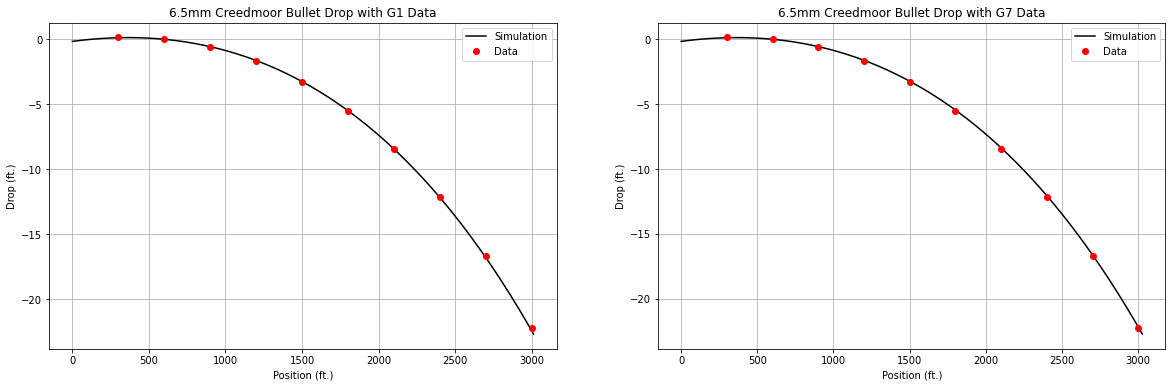

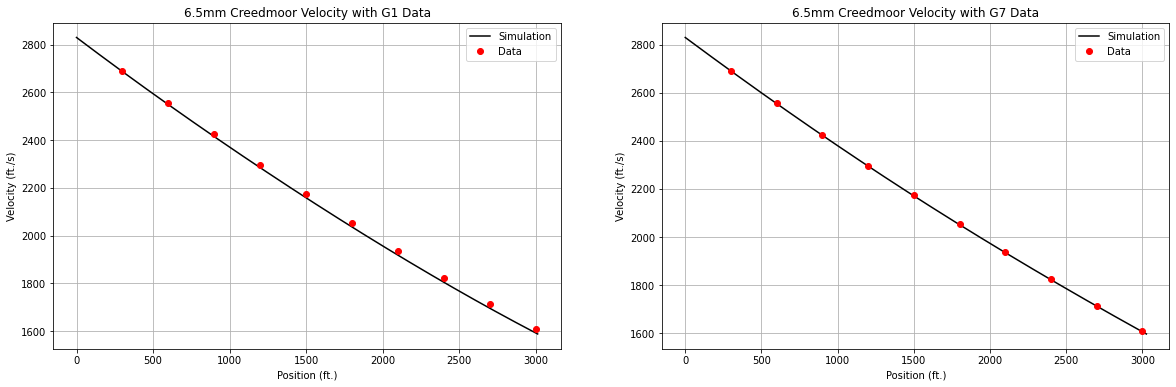

In [112]:
# Plot the results
# Bullet Drop
fig_d, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(y_g1[:, 0], y_g1[:, 1], 'k-')
axs[0].plot(bullet_data[:, 0], bullet_data[:, 2], 'ro')
axs[0].set_title('6.5mm Creedmoor Bullet Drop with G1 Data')
axs[0].legend(['Simulation', 'Data'])
axs[0].set(xlabel='Position (ft.)', ylabel='Drop (ft.)')
axs[0].grid()
axs[1].plot(y_g7[:, 0], y_g7[:, 1], 'k-')
axs[1].plot(bullet_data[:, 0], bullet_data[:, 2], 'ro')
axs[1].set_title('6.5mm Creedmoor Bullet Drop with G7 Data')
axs[1].legend(['Simulation', 'Data'])
axs[1].set(xlabel='Position (ft.)', ylabel='Drop (ft.)')
axs[1].grid()
plt.show()

# Velocity
fig_v, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(y_g1[:, 0], v_g1, 'k-')
axs[0].plot(bullet_data[:, 0], bullet_data[:, 1], 'ro')
axs[0].set_title('6.5mm Creedmoor Velocity with G1 Data')
axs[0].set(xlabel='Position (ft.)', ylabel='Velocity (ft./s)')
axs[0].legend(['Simulation', 'Data'])
axs[0].grid()
axs[1].plot(y_g7[:, 0], v_g7, 'k-')
axs[1].plot(bullet_data[:, 0], bullet_data[:, 1], 'ro')
axs[1].set_title('6.5mm Creedmoor Velocity with G7 Data')
axs[1].set(xlabel='Position (ft.)', ylabel='Velocity (ft./s)')
axs[1].legend(['Simulation', 'Data'])
axs[1].grid()
plt.show()


## My Computer is Better at Shooting than I Am ##

Hooray, that greatly improved my results with the G7 drag coefficients. The position error increased just slightly, but
that's okay since it was low to begin with, and the G1 velocity error is significantly worse, but I think that this is
also okay given that the G7 is a better physical representation of the bullet that I am modeling.


## Last Step: Does this work with a different bullet? ##


In [113]:
# Run simulation with the 300 Norma Magnum 230gr Hybrid OTM Tactical
# Has G1 BC: 0.717 lb/in^2
# And G7 BC: 0.368 lb/in^2
# with muzzle velocity 2934 ft/s
# https://bergerbullets.com/product/300-norma-magnum-230gr-hybrid-otm-tactical/

# Load in observed data for the above round
bullet_data = np.genfromtxt('./berger_300_norma_mag_230gr.txt')
bullet_data[:, 0] *= 3    # convert range from yards to feet
bullet_data[:, 2] /= 12   # Convert drop from inches to feet

# Ballistics Data for the round to the ballistics object
# Assume temp celsius = 15
air_density = 0.07647           # lb/ft^3
speed_of_sound = 1116.4         # ft/s
g1_ballistics = BallisticCoefficient('300 Norma Mag', bc=103.2, rho=air_density, vs=speed_of_sound,
                                 drag_ref_data=g1_drag_data, units='imperial')
g7_ballistics = BallisticCoefficient('6.5 Creedmoor', bc=52.99, rho=air_density, vs=speed_of_sound,
                                 drag_ref_data=g7_drag_data, units='imperial')

# Parameters for the ODE solver
t_range = np.array([0, 1.45])               # x range in feet
v_muzzle = 2934                             # ft/s
dist_between_barrel_and_scope = 0.164       # in feet

In [114]:
# Find an optimal theta
# STEP 1: Geometrically sample thetas
zero_drop_prev = 1000.
for n in np.geomspace(1, 80, num=20):
    theta = np.pi / 180 / n
    vx_0 = v_muzzle * np.cos(theta)  # Initial x velocity
    vy_0 = v_muzzle * np.sin(theta)  # Initial y velocity
    initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])  # position in inches, velocity in ft/s

    # Solve the ODE with the proposed value of theta
    t, y = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                                first_step=1e-4)

    # Compute the error at distance = 600 ft. (zero-distance) to evaluate the best theta
    zero_drop_interp = interpolate.interp1d(y[:, 0], y[:, 1], kind='quadratic')
    zero_drop = float(zero_drop_interp(600))
    if zero_drop < 0 and zero_drop_prev > 0:
        low_theta = theta
        break
    zero_drop_prev = zero_drop
    high_theta = theta

print(f'Best theta is in the range {low_theta}, {high_theta}')
# Now perform a fine search in the range [low_theta, high_theta]
best_theta = 0
best_error = 1000
for theta in np.linspace(low_theta, high_theta, 50):
    vx_0 = v_muzzle * np.cos(theta)  # Initial x velocity
    vy_0 = v_muzzle * np.sin(theta)  # Initial y velocity
    initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])  # position in inches, velocity in ft/s

    # Solve the ODE with the proposed value of theta
    t, y = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                                first_step=1e-4)

    # Compute the error at distance = 600 ft. (zero-distance) to evaluate the best theta
    zero_drop_interp = interpolate.interp1d(y[:, 0], y[:, 1], kind='quadratic')
    zero_drop = float(zero_drop_interp(600))
    error = np.square(zero_drop)
    if error < best_error:
        best_error = error
        best_theta = theta
print(f'new best theta is {best_theta} with error {best_error}')

Best theta is in the range 0.0013806653566087973, 0.0017388057138552572
new best theta is 0.001468373199199767 with error 1.4986943967651316e-06


In [115]:
# Now run the simulation with the improved theta and air density parameters
theta = best_theta
vx_0 = v_muzzle * np.cos(theta)             # Initial x velocity
vy_0 = v_muzzle * np.sin(theta)             # Initial y velocity
initial_state = np.array([0.0, -dist_between_barrel_and_scope, vx_0, vy_0])   # position in inches, velocity in ft/s
t_g1, y_g1 = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g1_ballistics,
                             first_step=1e-4)
t_g7, y_g7 = ode_solver.solve_ode(projectile, t_range, initial_state, ode_solver.EulerRichardson, g7_ballistics,
                             first_step=1e-4)
v_g1 = np.sqrt(y_g1[:, 2] ** 2 + y_g1[:, 3] ** 2)
v_g7 = np.sqrt(y_g7[:, 2] ** 2 + y_g7[:, 3] ** 2)

# Interpolate the simulated data to find the drop and velocity at the observed data distances
y_g1_interpolated = np.interp(bullet_data[:, 0], y_g1[:, 0], y_g1[:, 1])
v_g1_interpolated = np.interp(bullet_data[:, 0], y_g1[:, 0], v_g1)
y_g7_interpolated = np.interp(bullet_data[:, 0], y_g7[:, 0], y_g7[:, 1])
v_g7_interpolated = np.interp(bullet_data[:, 0], y_g7[:, 0], v_g7)

# Compute Errors for position and velocity between observed and simulated data
y_g1_error = bullet_data[:, 2] - y_g1_interpolated
v_g1_error = bullet_data[:, 1] - v_g1_interpolated
y_g7_error = bullet_data[:, 2] - y_g7_interpolated
v_g7_error = bullet_data[:, 1] - v_g7_interpolated

# Display the results
# G1 Table
table_g1 = PrettyTable()
table_g1.title = '300 Norma Mag Simulated Bullet Drop/Velocity with G1 Data'
table_g1.field_names = ['Distance (ft.)', *bullet_data[:, 0], 'RMSE']
table_g1.add_row(['Drop (ft)', *y_g1_interpolated, '-'])
table_g1.add_row(['Drop Error (ft)', *y_g1_error, np.sqrt(np.mean(y_g1_error)**2)])
table_g1.add_row(['Velocity (ft/s)', *v_g1_interpolated, '-'])
table_g1.add_row(['Velocity Error (ft/s)', *v_g1_error, np.sqrt(np.mean(v_g1_error)**2)])
table_g1.float_format = '0.3'
print(table_g1)

# G7 Table
table_g7 = PrettyTable()
table_g7.title = '300 Norma Mag Simulated Bullet Drop/Velocity with G7 Data'
table_g7.field_names = ['Distance (ft.)', *bullet_data[:, 0], 'RMSE']
table_g7.add_row(['Drop (ft)', *y_g7_interpolated, '-'])
table_g7.add_row(['Drop Error (ft)', *y_g7_error, np.sqrt(np.mean(y_g7_error)**2)])
table_g7.add_row(['Velocity (ft/s)', *v_g7_interpolated, '-'])
table_g7.add_row(['Velocity Error (ft/s)', *v_g7_error, np.sqrt(np.mean(v_g7_error)**2)])
table_g7.float_format = '0.3'
print()
print(table_g7)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                          300 Norma Mag Simulated Bullet Drop/Velocity with G1 Data                                          |
+-----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------+
|     Distance (ft.)    |  300.0   |  600.0   |  900.0   |  1200.0  |  1500.0  |  1800.0  |  2100.0  |  2400.0  |  2700.0  |  3000.0  |  RMSE |
+-----------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------+
|       Drop (ft)       |  0.103   |  -0.000  |  -0.510  |  -1.468  |  -2.921  |  -4.921  |  -7.528  | -10.809  | -14.843  | -19.716  |   -   |
|    Drop Error (ft)    |  0.019   |  0.000   |  -0.016  |  -0.029  |  -0.038  |  -0.042  |  -0.038  |  -0.025  |  -0.001  |  0.038   | 

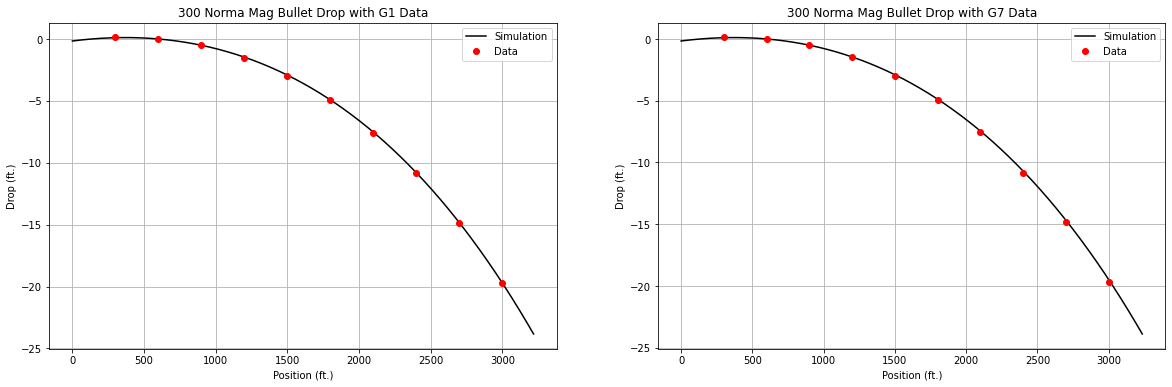

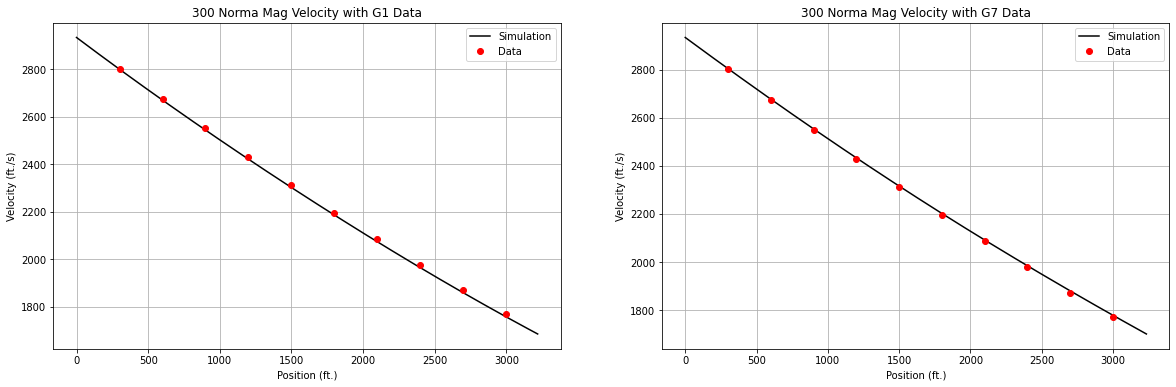

In [116]:
# Plot the results
# Bullet Drop
fig_d, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(y_g1[:, 0], y_g1[:, 1], 'k-')
axs[0].plot(bullet_data[:, 0], bullet_data[:, 2], 'ro')
axs[0].set_title('300 Norma Mag Bullet Drop with G1 Data')
axs[0].legend(['Simulation', 'Data'])
axs[0].set(xlabel='Position (ft.)', ylabel='Drop (ft.)')
axs[0].grid()
axs[1].plot(y_g7[:, 0], y_g7[:, 1], 'k-')
axs[1].plot(bullet_data[:, 0], bullet_data[:, 2], 'ro')
axs[1].set_title('300 Norma Mag Bullet Drop with G7 Data')
axs[1].legend(['Simulation', 'Data'])
axs[1].set(xlabel='Position (ft.)', ylabel='Drop (ft.)')
axs[1].grid()
plt.show()

# Velocity
fig_v, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(y_g1[:, 0], v_g1, 'k-')
axs[0].plot(bullet_data[:, 0], bullet_data[:, 1], 'ro')
axs[0].set_title('300 Norma Mag Velocity with G1 Data')
axs[0].set(xlabel='Position (ft.)', ylabel='Velocity (ft./s)')
axs[0].legend(['Simulation', 'Data'])
axs[0].grid()
axs[1].plot(y_g7[:, 0], v_g7, 'k-')
axs[1].plot(bullet_data[:, 0], bullet_data[:, 1], 'ro')
axs[1].set_title('300 Norma Mag Velocity with G7 Data')
axs[1].set(xlabel='Position (ft.)', ylabel='Velocity (ft./s)')
axs[1].legend(['Simulation', 'Data'])
axs[1].grid()
plt.show()

## Final Thoughts ##
The new bullet performs well with the model and its improvements. The position drop error is is spectaularly low, but
the velocity error is significantly higher compared to my simulated 6.5 Creedmoor. However, the results from this test
show that the model is robust across different bullets.